## File 03: Exploratory Data Analysis, Individual Level
##### Group 12:

##### Hannah Schmuckler, mmc4cv

##### Rob Schwartz, res7cd

At a minimum, the file should include a summary containing:
* Number of records
* Number of columns
* Statistical summary of response variable
* Statistical summary of potential predictor variables (if there are a large number of predictors, select the top 10)
* Note: Summarize categorical variables with counts and percentages for each level and summarize numerical variables with mean/quantiles/standard deviation.
* Include up to five helpful graphs

In [2]:
%%time
from pyspark.sql import SparkSession
from pyspark.sql import types as T
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
import pandas as pd
import pyspark.sql.functions as f
from pyspark.sql.window import Window
from pyspark.sql.functions import col
from pyspark.sql.functions import log
from matplotlib.pyplot import figure



import sys
spark = SparkSession.builder \
        .appName("project") \
        .getOrCreate()

sc = spark.sparkContext

CPU times: user 539 ms, sys: 487 ms, total: 1.03 s
Wall time: 5.83 s


### Read in data

#### Note: Our data was originally formatted in a 'tall' file forma with 9 columns:
* event_time
* event_type
* product_id
* category_code
* brand
* price
* user_id
* user_session

It was also significantly larger than the 3gb limitation for class. However, our question required us to filter the data to only those who made a purchase in the first month, which reduced the size to a manageable level. 

All of the features in the dataset below have been engineered by us on an individual level, instead of the event-level data originally provided. 

In [3]:
full = spark.read.parquet("./processed_data/engineered_features.parquet")

In [4]:
full.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- total_spend: double (nullable = true)
 |-- total_events: long (nullable = true)
 |-- total_sessions: long (nullable = true)
 |-- T_total_spend: double (nullable = true)
 |-- avg_session_length: double (nullable = true)
 |-- sd_session_length: double (nullable = true)
 |-- avg_interactions_per_session: double (nullable = true)
 |-- sd_interactions_per_session: double (nullable = true)
 |-- max_interactions_per_session: long (nullable = true)
 |-- purchase_pct_of_total_events: double (nullable = true)
 |-- view_pct_of_total_events: double (nullable = true)
 |-- cart_pct_of_total_events: double (nullable = true)
 |-- avg_purchases_per_session: double (nullable = true)
 |-- sd_purchases_per_session: double (nullable = true)
 |-- cart_events: long (nullable = true)
 |-- purchase_events: long (nullable = true)
 |-- view_events: long (nullable = true)
 |-- sessions_with_purchase: long (nullable = true)
 |-- sessions_with_cart: long (nullable =

In [5]:
# Number of columns
len(full.schema)

29

##### A single record looks like this:

In [6]:
%%time
full.show(1, vertical=True)

-RECORD 0--------------------------------------------
 user_id                      | 435055582            
 total_spend                  | 159.72000122070312   
 total_events                 | 77                   
 total_sessions               | 59                   
 T_total_spend                | 159.72000122070312   
 avg_session_length           | 121.45762711864407   
 sd_session_length            | 621.2218028578814    
 avg_interactions_per_session | 1.305084745762712    
 sd_interactions_per_session  | 1.118099330732286    
 max_interactions_per_session | 9                    
 purchase_pct_of_total_events | 0.012987012987012988 
 view_pct_of_total_events     | 0.961038961038961    
 cart_pct_of_total_events     | 0.025974025974025976 
 avg_purchases_per_session    | 0.01694915254237288  
 sd_purchases_per_session     | 0.13018891098082386  
 cart_events                  | 2                    
 purchase_events              | 1                    
 view_events                

In [7]:
%%time
## Note: We have not yet determined our best predictors, but perhaps looking at these outputs will help us.
for i in range(1,len(full.columns)):
    j = full.columns[i]
    full.select(j).summary().show()

+-------+------------------+
|summary|       total_spend|
+-------+------------------+
|  count|            359045|
|   mean| 725.9766045853055|
| stddev| 2120.897366507493|
|    min| 0.800000011920929|
|    25%| 122.5999984741211|
|    50%| 257.3800048828125|
|    75%| 713.9100189208984|
|    max|294910.72656440735|
+-------+------------------+

+-------+-----------------+
|summary|     total_events|
+-------+-----------------+
|  count|           359045|
|   mean|44.08205099639321|
| stddev|70.67533822699541|
|    min|                1|
|    25%|               10|
|    50%|               22|
|    75%|               50|
|    max|             1962|
+-------+-----------------+

+-------+-----------------+
|summary|   total_sessions|
+-------+-----------------+
|  count|           359045|
|   mean|7.361208205099639|
| stddev| 9.65035095697956|
|    min|                1|
|    25%|                2|
|    50%|                4|
|    75%|                9|
|    max|              292|
+-----

Here is our original dataset so we can do some basic summary of things like product_id, brand and individual price. 

Note that period is a feature that we added after filtering the data to easily keep track of which month a given row is from. This is the month 1 dataset, where all our predictors will come from. The month 2 dataset (not in this document) has been aggregated above to produce our response variable. 

In [8]:
m1 = spark.read.parquet('./processed_data/month_01_filtered.parquet')

In [9]:
m1.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: float (nullable = true)
 |-- user_session: string (nullable = true)



In [10]:
# Number of columns
len(m1.schema)

9

In [11]:
m1.select('event_type').distinct().count()
# There are 3 types of events

3

In [12]:
%%time
m1.select('product_id').distinct().count()
# There are 181,283 different products. 

CPU times: user 764 µs, sys: 1.72 ms, total: 2.48 ms
Wall time: 1.68 s


181283

In [13]:
%%time
m1.select('category_code').distinct().count()
# There are 136 different categories

CPU times: user 2.07 ms, sys: 67 µs, total: 2.14 ms
Wall time: 993 ms


136

In [14]:
%%time
m1.select('brand').distinct().count()
# There are 4770 different brands

CPU times: user 2.28 ms, sys: 253 µs, total: 2.53 ms
Wall time: 1.02 s


4770

In [15]:
m1.describe('price').show()

+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|          15923973|
|   mean| 272.8108554043269|
| stddev|334.88693997298145|
|    min|               0.0|
|    max|           2574.07|
+-------+------------------+



In [16]:
%%time
m1.select('user_session').distinct().count()
# There are 2697902 different user sessions

CPU times: user 955 µs, sys: 1.96 ms, total: 2.92 ms
Wall time: 2.54 s


2697902

### Visualization

##### Response Variable: Spend in month 2

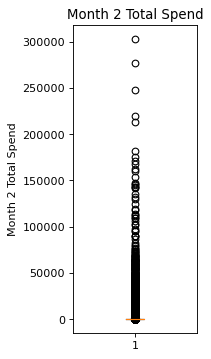

In [27]:
figure(figsize=(2,5), dpi=80)
response = full.select('T_total_spend').toPandas()['T_total_spend']
plt.boxplot(response)
plt.title('Month 2 Total Spend')
plt.ylabel('Month 2 Total Spend')
plt.show()

That's essentially useless, we're obviously going to have to do some transformation on our response and remove outliers, but here's a histogram:

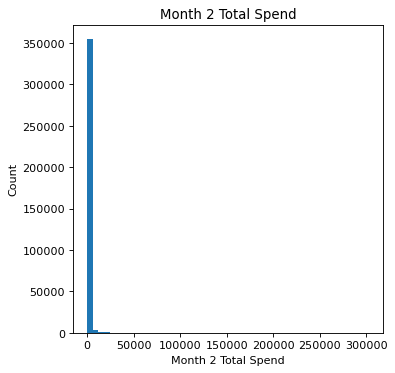

In [28]:
figure(figsize=(5,5), dpi=80)

plt.hist(response, bins = 50)
plt.title('Month 2 Total Spend')
plt.xlabel('Month 2 Total Spend')
plt.ylabel('Count')
plt.show()

What does it look like log-transformed? That might be more useful. 

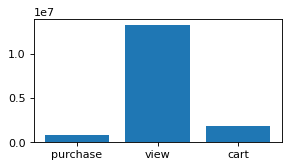

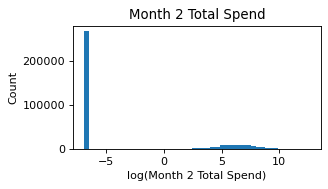

In [34]:
figure(figsize=(4, 2), dpi=80)

response = full.select('T_total_spend_log').toPandas()['T_total_spend_log']
plt.hist(response, bins = 50)
plt.title('Month 2 Total Spend')
plt.xlabel('log(Month 2 Total Spend)')
plt.ylabel('Count')
plt.show()

### Just to get an idea of how common purchases are...

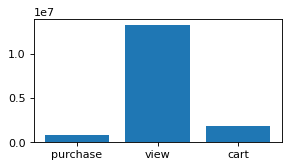

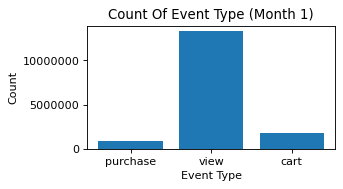

In [36]:
events = m1.groupBy('event_type').count()
x = events.select('event_type').toPandas()['event_type']
y = events.select('count').toPandas()['count']

figure(figsize=(4, 2), dpi=80)
plt.bar(x, y)
plt.ticklabel_format(axis="y", style='plain')
plt.title("Count Of Event Type (Month 1)")
plt.xlabel("Event Type")
plt.ylabel("Count")


plt.show()

#### To get an idea of the variation in behavior...standard deviation of interactions per session

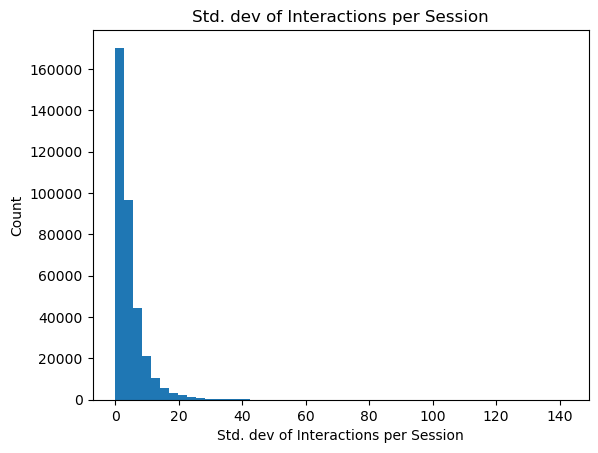

In [38]:
response = full.select('sd_interactions_per_session').toPandas()['sd_interactions_per_session']

plt.hist(response, bins = 50)
plt.title('Std. dev of Interactions per Session')
plt.xlabel('Std. dev of Interactions per Session')
plt.ylabel('Count')
plt.show()

#### Average Purchases Per Session

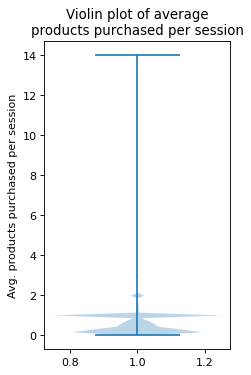

In [43]:

figure(figsize=(3, 5), dpi=80)
response = full.select('avg_purchases_per_session').toPandas()['avg_purchases_per_session']
plt.violinplot(response)

plt.title('Violin plot of average\nproducts purchased per session')
plt.ylabel('Avg. products purchased per session')
plt.show()
